In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore")

## **Moving Average Models for Forecasting**

The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure. A simple autoregression model of this structure can be used to predict the forecast error, which in turn can be used to correct forecasts. This type of model is called a moving average model, the same name but very different from moving average smoothing.

**Model of Residual Errors**

The difference between what was expected and what was predicted is called the residual error. It is calculated as:

$\ residual\_error = expected-predicted$

Just like the input observations themselves, the residual errors from a time series can have temporal structure like trends, bias, and seasonality. Any temporal structure in the time series of residual forecast errors is useful as a diagnostic as it suggests information that could be incorporated into the predictive model. An ideal model would leave no structure in the residual error, just random fluctuations that cannot be modeled.

Structure in the residual error can also be modeled directly. There may be complex signals in the residual error that are difficult to directly incorporate into the model. Instead, you can create a model of the residual error time series and predict the expected error for your model. The predicted error can then be subtracted from the model prediction and in turn provide an additional lift in performance.

A simple and effective model of residual error is an autoregression. This is where some number of lagged error values are used to predict the error at the next time step. These lag errors are combined in a linear regression model, much like an autoregression model of the direct time series observations. An autoregression of the residual error time series is called a Moving Average (MA) model. This is confusing because it has nothing to do with the moving average smoothing process. Think of it as the sibling to the autoregressive (AR) process, except on lagged residual error rather than lagged raw observations.

**Persistence Forecast Model**

The simplest forecast that we can make is to forecast that what happened in the previous time step will be the same as what will happen in the next time step. This is called the naive forecast or the persistence forecast model.

*This model will provide the predictions from which we can calculate the residual error time series. Alternately, we could develop an autoregression model of the time series and use that as our model. We will not develop an autoregression model in this case for brevity and to focus on the model of residual error.*

In [9]:
from sklearn.metrics import mean_squared_error
series = pd.read_csv("daily-total-female-births.csv",index_col=0,header=0,squeeze=True, parse_dates=True)

# Create lagged plot of dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# Split into train and test sets 
X = dataframe.values
train_size = int(len(X) * 0.66)
train,test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistance model
predictions = [x for x in test_X]

# Skill of persistance model
rmse = mean_squared_error(test_y,predictions,squared=False)
print(f"RMSE: {np.round(rmse,4)}")

# Calculate residuals 
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.head()

RMSE: 9.1512


,0
0,9.0
1,-10.0
2,3.0
3,-6.0
4,30.0


**Autoregression of Residual Error**

We can model the residual error time series using an autoregression model. This is a linear regression model that creates a weighted linear sum of lagged residual error terms. For example:

$\ error(t+1) = b_0 + (b_1\times error(t)) + (b_2 \times error(t - 1))....+ (b_n\times error(t-n))$

We can use the autoregression model (AR) provided by the Statsmodels library. Building on the persistence model in the previous section, we can first train the model on the residual errors calculated on the training dataset. This requires that we make persistence predictions for each observation in the training dataset, then create the AR model, as follows.

In [10]:
from statsmodels.tsa.ar_model import AutoReg


# persistance model for training set
train_pred = [x for x in train_X]
# Calculate residuals
train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# model the training set residuals
model = AutoReg(train_resid,lags=15)
model_fit = model.fit()
window = len(model_fit.ar_lags)
coef = model_fit.params
print(f"Lag: {window}")
print(f"Coefficicents: {coef}")

Lag: 15
Coefficicents: [ 0.10120699 -0.84940615 -0.77783609 -0.73345006 -0.68902061 -0.59270551
 -0.5376728  -0.42553356 -0.24861246 -0.19972102 -0.15954013 -0.11045476
 -0.14045572 -0.13299964 -0.12515801 -0.03615774]


Next, we can step through the test dataset and for each time step we must:
1. Calculate the persistence prediction (t+1 = t).
2. Predict the residual error using the autoregression model. 

The autoregression model requires the residual error of the 15 previous time steps. Therefore, we must keep these values handy. As we step through the test dataset timestep by timestep making predictions and estimating error, we can then calculate the actual residual error and update the residual error time series lag values (history) so that we can calculate the error at the next time step.

This is a walk forward forecast, or a rolling forecast, model. We end up with a time series of the residual forecast error from the train dataset and a predicted residual error on the test dataset. We can plot these and get a quick idea of how skillful the model is at predicting residual error.

In [11]:
# series = pd.read_csv("daily-total-female-births.csv",index_col=0,header=0,squeeze=True, parse_dates=True)
# # Create lagged plot of dataset
# values = pd.DataFrame(series.values)
# dataframe = pd.concat([values.shift(1), values], axis=1)
# dataframe.columns = ['t', 't+1']

# # Split into train and test sets 
# X = dataframe.values
# train_size = int(len(X) * 0.66)
# train,test = X[1:train_size], X[train_size:]
# train_X, train_y = train[:,0], train[:,1]
# test_X, test_y = test[:,0], test[:,1]

# # persistance model for training set
# train_pred = [x for x in train_X]
# # Calculate residuals
# train_resid = [train_y[i]-train_pred[i] for i in range(len(train_pred))]
# # model the training set residuals
# model = AutoReg(train_resid,lags=15)
# model_fit = model.fit()
# window = len(model_fit.ar_lags)
# coef = model_fit.params

# https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
# print(history)
history = [history[i] for i in range(len(history))]
# print(history)
print(len(history))
predictions = []
expected_error = []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error+= coef[d+1] * lag[window-d-1]
    predictions.append(pred_error)
    history.append(error)
    print(f"Predicted error: {pred_error}, Expected error: {error}")

15
Predicted error: 1.1555234505436442, Expected error: 9.0
Predicted error: -7.108809328513027, Expected error: -10.0
Predicted error: 3.007486295261616, Expected error: 3.0
Predicted error: -0.7564456532827145, Expected error: -6.0
Predicted error: 5.511162863062301, Expected error: 30.0
Predicted error: -19.991263589729915, Expected error: -28.0
Predicted error: 4.842428861994539, Expected error: 2.0
Predicted error: 3.0508830541985867, Expected error: 9.0
Predicted error: -5.141585338791684, Expected error: -7.0
Predicted error: 1.1611191585591765, Expected error: 1.0
Predicted error: -0.2419284443155618, Expected error: -9.0
Predicted error: 9.159826043597493, Expected error: 21.0
Predicted error: -7.117973673885669, Expected error: -13.0
Predicted error: 1.1829921745309886, Expected error: -2.0
Predicted error: 2.769362582686582, Expected error: 11.0
Predicted error: -4.959336643853724, Expected error: -11.0
Predicted error: 2.5662325149881937, Expected error: -8.0
Predicted erro

Text(0.5, 1.0, 'Expected residual error (blue) and Forecast residual error (red) plot')

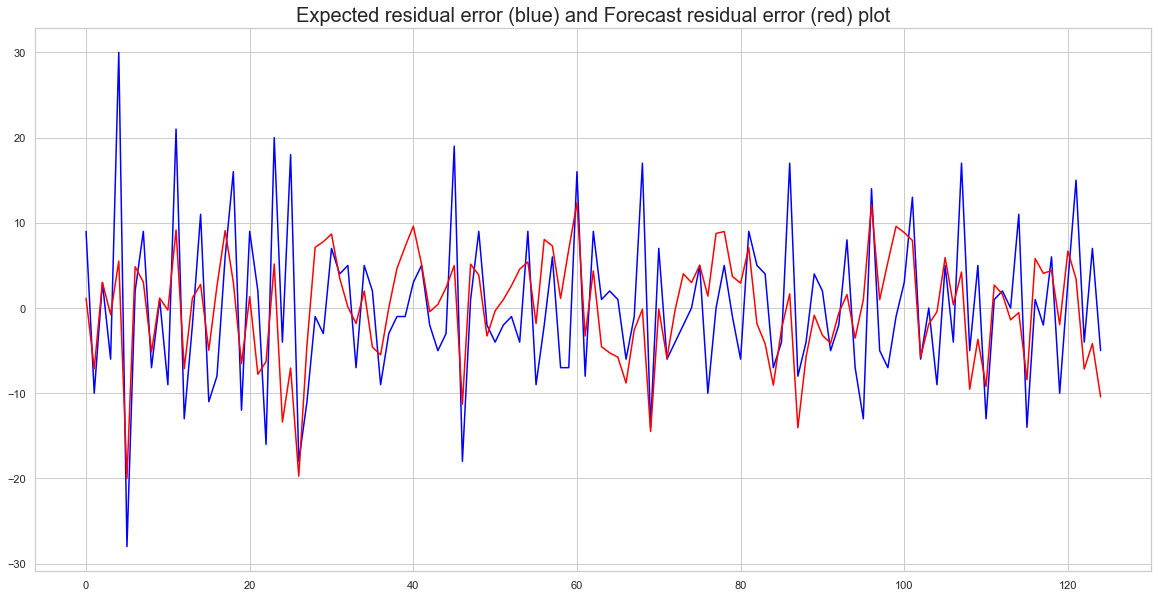

In [12]:
# Plotting the test and predictions 
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
sns.lineplot(data=expected_error,color="blue")
sns.lineplot(data=predictions, color='red')
ax.set_title(f"Expected residual error (blue) and Forecast residual error (red) plot",fontdict={'fontsize':20})

**Correct Predictions with a Model of Residuals**

A model of forecast residual error is interesting, but it can also be useful to make better predictions. With a good estimate of forecast error at a time step, we can make better predictions. For example, we can add the expected forecast error to a prediction to correct it and in turn improve the skill of the model.

$\ improved\_ forecast = forecast + estimated\_error$


In [13]:
# correct forecasts with a model of forecast residual errors

# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
# print(history)
history = [history[i] for i in range(len(history))]
# print(history)
print(len(history))
predictions = []
expected_error = []

for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]
    error = test_y[t] - yhat
    expected_error.append(error)
    
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error+= coef[d+1] * lag[window-d-1]
    
    # Correct prediction 
    yhat = yhat + pred_error
    predictions.append(yhat)
    history.append(error)
    print(f"Predicted: {yhat}, Expected: {test_y[t]}")

# Error
rmse = mean_squared_error(test_y,predictions,squared=False)
print(f"Test RMSE: {rmse}")

15
Predicted: 43.15552345054365, Expected: 51.0
Predicted: 43.891190671486974, Expected: 41.0
Predicted: 44.007486295261614, Expected: 44.0
Predicted: 43.24355434671728, Expected: 38.0
Predicted: 43.5111628630623, Expected: 68.0
Predicted: 48.00873641027009, Expected: 40.0
Predicted: 44.84242886199454, Expected: 42.0
Predicted: 45.050883054198586, Expected: 51.0
Predicted: 45.858414661208315, Expected: 44.0
Predicted: 45.161119158559174, Expected: 45.0
Predicted: 44.75807155568444, Expected: 36.0
Predicted: 45.15982604359749, Expected: 57.0
Predicted: 49.88202632611433, Expected: 44.0
Predicted: 45.18299217453099, Expected: 42.0
Predicted: 44.76936258268658, Expected: 53.0
Predicted: 48.040663356146275, Expected: 42.0
Predicted: 44.566232514988194, Expected: 34.0
Predicted: 43.08449838033526, Expected: 40.0
Predicted: 43.02089920670632, Expected: 56.0
Predicted: 49.45790249081935, Expected: 44.0
Predicted: 45.32811585365674, Expected: 53.0
Predicted: 45.22558832953407, Expected: 55.0
P

Text(0.5, 1.0, 'Expected values (blue) and Forecast values (red) plot')

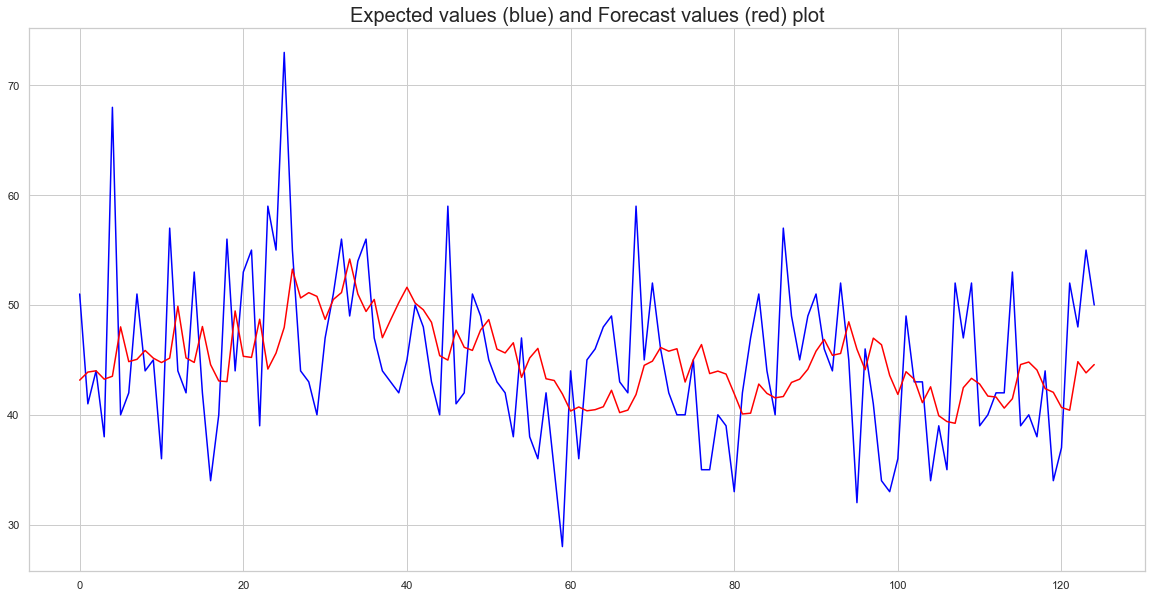

In [14]:
# Plotting the test and predictions 
fig,ax = plt.subplots(figsize=(20,10))
sns.set_theme(style='whitegrid')
sns.lineplot(data=test_y,color="blue")
sns.lineplot(data=predictions, color='red')
ax.set_title(f"Expected values (blue) and Forecast values (red) plot",fontdict={'fontsize':20})